In [8]:

import os
from os.path import join
import yaml
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('./paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm
import torch

import ili
from ili.dataloaders import StaticNumpyLoader, SBISimulator
from ili.validation.runner import ValidationRunner 
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


from CASBI.generator.fff.fff_model import FreeFormFlow
from CASBI.utils.create_dataframe import rescale


In [11]:
data = pd.read_parquet('../../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameter=True, inverse=True)
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
conditions = data[data.columns.difference(['feh', 'ofe', 'Galaxy_name'], sort=False)].drop_duplicates()
n_halos=3
minimum_theta = [conditions[col].values.min() for col in conditions.columns]   
maximum_theta = [conditions[col].values.max() for col in conditions.columns]       
minimum_theta = np.array(minimum_theta)
maximum_theta = np.array(maximum_theta)
def repeat_array(arr, repetitions):
    return np.repeat(arr, repetitions)
repeat_minimum_theta = repeat_array(minimum_theta, n_halos)
repeat_maximum_theta = repeat_array(maximum_theta, n_halos) 

def write_to_yaml(repeat_minimum_theta, repeat_maximum_theta):
    # Load the existing data
    with open('./training.yaml', 'r') as file:
        data = yaml.safe_load(file)

    repeat_minimum_theta = repeat_minimum_theta.tolist()
    repeat_maximum_theta = repeat_maximum_theta.tolist()
    # Update the value
    data['prior']['args']['low'] = repeat_minimum_theta
    data['prior']['args']['high'] = repeat_maximum_theta

    # Write the data back to the file
    with open('./training.yaml', 'w') as file:
        yaml.safe_dump(data, file)
        
write_to_yaml(repeat_minimum_theta, repeat_maximum_theta)

In [4]:
samples = {}
m = 'NPE'
with open(join('./', 'toy_NPE_posterior.pkl'), 'rb') as f:
    samples[m] = pickle.load(f)
posterio_samples = samples['NPE'].sample((3_000,), x=torch.from_numpy(np.load('./x_0.npy')).to('cuda'))

Drawing 3000 posterior samples:   0%|          | 0/3000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

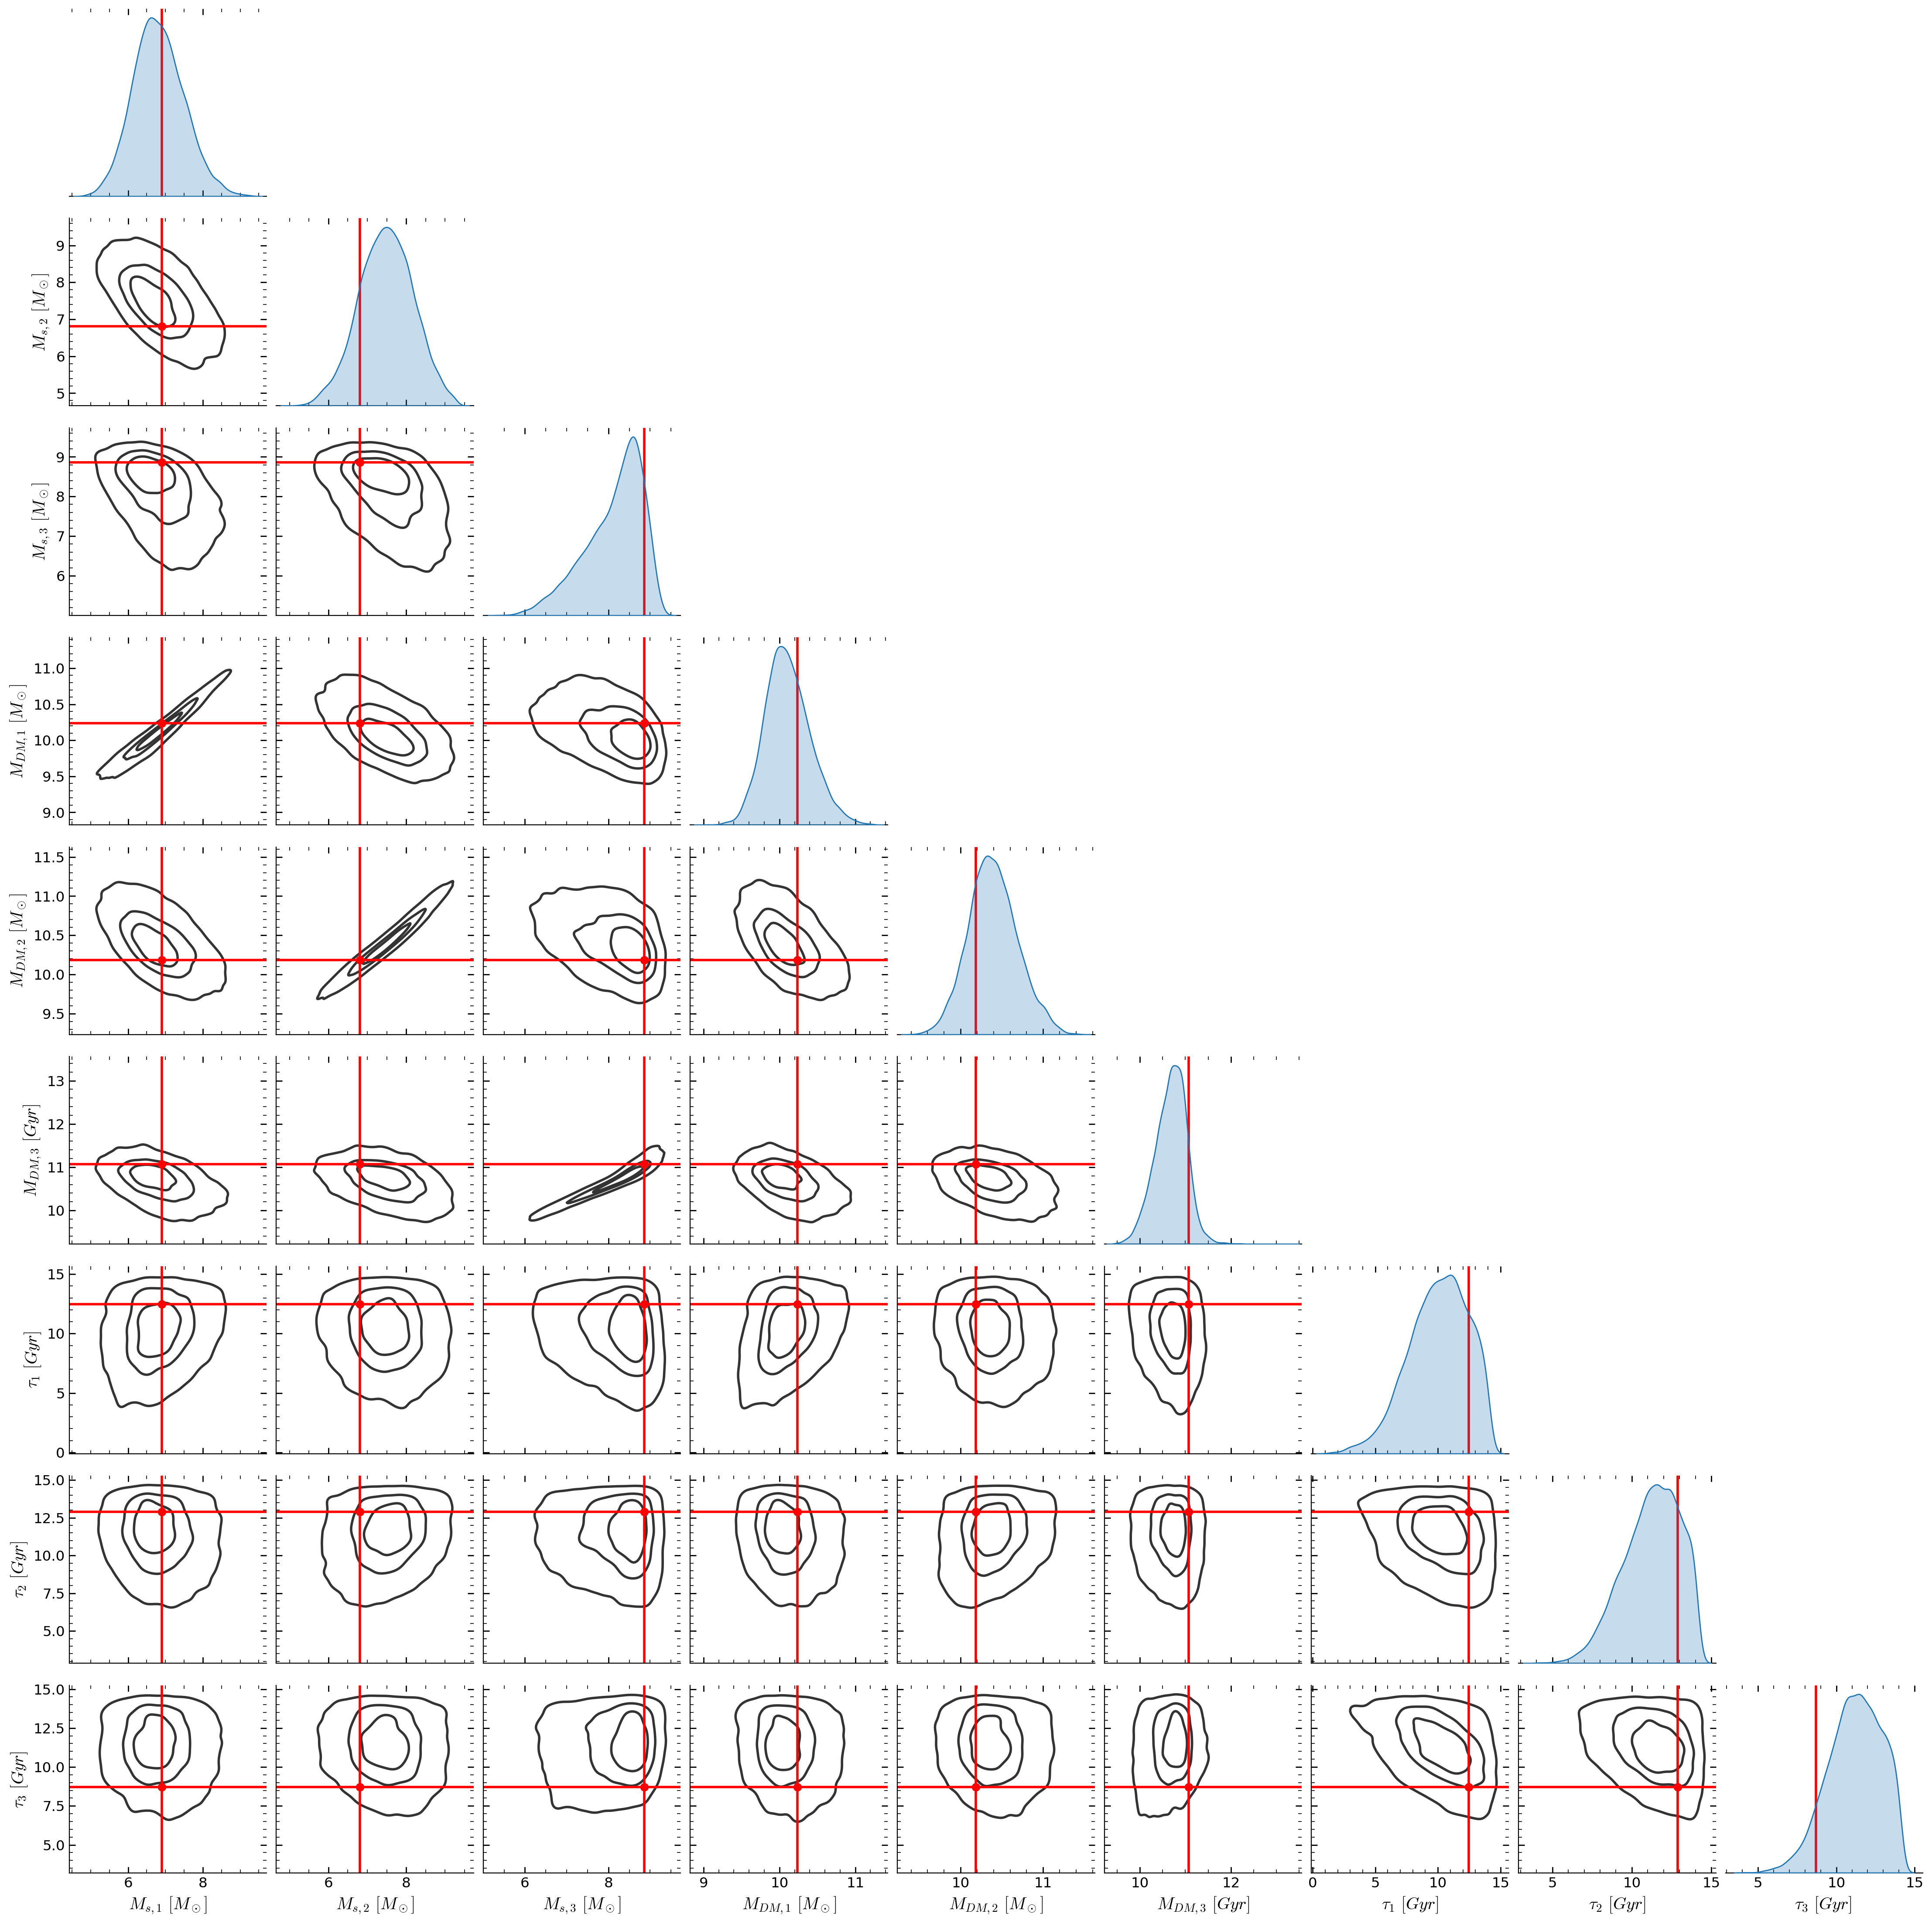

In [11]:
metric = PlotSinglePosterior(
    num_samples=10_000, sample_method='direct', 
    labels = [r'$M_{s, 1}\ [M_\odot]$', r'$M_{s, 2}\ [M_\odot]$', r'$M_{s, 3}\ [M_\odot]$', r'$M_{DM, 1}\ [M_\odot]$', r'$M_{DM, 2}\ [M_\odot]$', r'$M_{DM, 3}\ [Gyr]$', r'$\tau_{1}\ [Gyr]$', r'$\tau_{2}\ [Gyr]$', r'$\tau_{3}\ [Gyr]$ '],
    out_dir=None
)
fig = metric(
    posterior=samples[m],
    x_obs = torch.from_numpy(np.load('./x_0.npy')), theta_fid=torch.from_numpy(np.load('./theta_0.npy')),
)

In [12]:
import numpy as np
import pandas as pd
from multiprocessing import Pool

N_subhalos = 3
galaxies_0 = data['Galaxy_name'].sample(N_subhalos)
theta_0 =  data[data['Galaxy_name'].isin(galaxies_0)].drop(['feh', 'ofe', 'Galaxy_name'], axis=1).drop_duplicates().values.T.reshape(-1)
galaxy_data = data[data['Galaxy_name'].isin(galaxies_0)].values
histogram_galaxy, _, _ = np.histogram2d(galaxy_data[:, 0], galaxy_data[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
x_0 =  np.expand_dims(np.log10(histogram_galaxy + 1e-6 +1), axis=0)

N=5_000
def process_sample(i):
    galaxies = data['Galaxy_name'].drop_duplicates().sample(n_halos, random_state=i)
    while set(galaxies) == set(galaxies_0):
        print('matched galaxies, try again')
        galaxies = data['Galaxy_name'].drop_duplicates().sample(n_halos, random_state=i)
    parameters =  data[data['Galaxy_name'].isin(galaxies)].drop(['feh', 'ofe', 'Galaxy_name'], axis=1).drop_duplicates().values.T.reshape(-1)
    galaxy_data = data[data['Galaxy_name'].isin(galaxies)].values
    histogram_galaxy, _, _ = np.histogram2d(galaxy_data[:, 0], galaxy_data[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    sim_data =  np.expand_dims(np.log10(histogram_galaxy + 1e-6 +1), axis=0)
    return parameters, sim_data

# Create a pool of workers
with Pool() as pool:
    # Map the function to the data
    results = pool.map(process_sample, range(N))

# Unpack the results
theta, x = zip(*results)

# Convert to numpy arrays
theta = torch.from_numpy(np.array(theta)).float()
x = torch.from_numpy(np.array(x)).float()

In [25]:
np.save('./x_0.npy', x_0)
np.save('./theta_0.npy', theta_0)


np.save('./x.npy', x.numpy())
np.save('./theta.npy', theta.numpy())